NAME: Naveen Jajapur

# Machine Learning Practice - In-Person
# Homework C: Classifiers

## Objectives
* Compute class labels from raw data
* Use your imputing/filtering skills to clean up raw data
* Implement a classifier that predicts robot motion from infant movements
* Evaluate the classifier by:
  + Computing TPR/FPRs
  + Displaying their CDFs
  + Displaying the corresponding ROC curve

## Instructions
* All Homework must be individual work.  Do not look at or copy solutions of other students or that are available on the Internet or via LLMs
* Only work in a copy of the file that is from your ~/homework_in/ directory
   + __If you do not use your own copy of this file, then it is an automatic zero on the assignment__
* Read the code below 
* For any cell that is flagged as *TODO*, complete the code according to the specifications
* Execute each cell and verify that it is showing correct results
* Hand-In Procedure
  + Make sure that your notebook has been saved.  You are responsible for ensuring that the copy that you submit is current and complete
  + The name of the file should be the same as what we gave you
  + Download this file to your local machine (extension: .ipynb)
  + Submit to the Gradescope Notebook HWC dropbox
  

## General References
* [Python Built-in Functions](https://docs.python.org/3/library/functions.html)
* [Python Data Structures](https://docs.python.org/3/tutorial/datastructures.html)
* [Numpy Reference](https://docs.scipy.org/doc/numpy/reference/index.html)
* [Summary of matplotlib](https://matplotlib.org/3.1.1/api/pyplot_summary.html)
* [Pandas DataFrames](https://urldefense.proofpoint.com/v2/url?u=https-3A__pandas.pydata.org_pandas-2Ddocs_stable_reference_api_pandas.DataFrame.html&d=DwMD-g&c=qKdtBuuu6dQK9MsRUVJ2DPXW6oayO8fu4TfEHS8sGNk&r=9ngmsG8rSmDSS-O0b_V0gP-nN_33Vr52qbY3KXuDY5k&m=mcOOc8D0knaNNmmnTEo_F_WmT4j6_nUSL_yoPmGlLWQ&s=h7hQjqucR7tZyfZXxnoy3iitIr32YlrqiFyPATkW3lw&e=)
* [Sci-kit Learn Linear Models](https://scikit-learn.org/stable/api/sklearn.linear_model.html)
  + [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)
* [Sci-kit Learn Ensemble Models](https://scikit-learn.org/stable/api/sklearn.ensemble.html)
* [Sci-kit Learn Metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html)
* [Sci-kit Learn Model Selection](https://scikit-learn.org/stable/api/sklearn.model_selection.html)


In [61]:
# EXECUTE CELL

import pandas as pd
import numpy as np
import os, re, fnmatch
import matplotlib.pyplot as plt
import matplotlib.patheffects as peffects

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
import scipy.stats as stats

# Default figure parameters
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

%matplotlib inline

# LOAD DATA

In [62]:
""" TODO
Load data from subject k3 for week 15
Display info() for the data

These are data obtained from a baby on the SIPPC. 3D Position (i.e. kinematic)
data are collected at 50 Hz, for the x, y, and z positions in meters, for 
various joints such as the wrists, elbows, shoulders, etc.
"""
# Local file name
#  UPDATE
fname = '/mlp/datasets/baby1/subject_k3_w15.csv'


baby_data_raw = pd.read_csv(fname)
baby_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              15000 non-null  float64
 1   left_wrist_x      15000 non-null  float64
 2   left_wrist_y      15000 non-null  float64
 3   left_wrist_z      15000 non-null  float64
 4   right_wrist_x     15000 non-null  float64
 5   right_wrist_y     15000 non-null  float64
 6   right_wrist_z     15000 non-null  float64
 7   left_elbow_x      15000 non-null  float64
 8   left_elbow_y      15000 non-null  float64
 9   left_elbow_z      15000 non-null  float64
 10  right_elbow_x     15000 non-null  float64
 11  right_elbow_y     15000 non-null  float64
 12  right_elbow_z     15000 non-null  float64
 13  left_shoulder_x   15000 non-null  float64
 14  left_shoulder_y   15000 non-null  float64
 15  left_shoulder_z   15000 non-null  float64
 16  right_shoulder_x  15000 non-null  float6

In [63]:
""" TODO
Display the first few examples
"""
 # TODO
print(baby_data_raw.head())

   time  left_wrist_x  left_wrist_y  left_wrist_z  right_wrist_x   
0  0.00      0.153437      0.183000     -0.207128       0.229132  \
1  0.02      0.153553      0.182963     -0.207118       0.229110   
2  0.04      0.153486      0.183022     -0.207149       0.229224   
3  0.06      0.153628      0.182978     -0.207179       0.229177   
4  0.08      0.153594      0.182985     -0.207237       0.229241   

   right_wrist_y  right_wrist_z  left_elbow_x  left_elbow_y  left_elbow_z   
0      -0.249933      -0.069966      0.175469      0.162546     -0.109485  \
1      -0.249869      -0.069907      0.175510      0.162502     -0.109460   
2      -0.249865      -0.069893      0.175489      0.162518     -0.109510   
3      -0.249803      -0.069835      0.175552      0.162483     -0.109520   
4      -0.249890      -0.069791      0.175548      0.162482     -0.109586   

   ...  left_foot_z  right_foot_x  right_foot_y  right_foot_z  upper_back_x   
0  ...    -0.109114     -0.273704     -0.042524  

In [64]:
""" TODO
Display the last few examples
"""
 # TODO
print(baby_data_raw.tail())

         time  left_wrist_x  left_wrist_y  left_wrist_z  right_wrist_x   
14995  299.90      0.173099      0.072664     -0.174599       0.215740  \
14996  299.92      0.174961      0.072236     -0.174677       0.217195   
14997  299.94      0.176475      0.071759     -0.174865       0.218167   
14998  299.96      0.177859      0.071356     -0.174991       0.218725   
14999  299.98      0.178896      0.070962     -0.175224       0.218569   

       right_wrist_y  right_wrist_z  left_elbow_x  left_elbow_y  left_elbow_z   
14995      -0.181244      -0.043348      0.163338      0.091591     -0.074677  \
14996      -0.181111      -0.043557      0.164295      0.090913     -0.074800   
14997      -0.180734      -0.044091      0.165167      0.090271     -0.075028   
14998      -0.180417      -0.045049      0.165920      0.089666     -0.075190   
14999      -0.179720      -0.046115      0.166566      0.089178     -0.075453   

       ...  left_foot_z  right_foot_x  right_foot_y  right_foot_z   

In [65]:
""" TODO
Display the summary statistics
"""
 # TODO
print(baby_data_raw.describe())

               time  left_wrist_x  left_wrist_y  left_wrist_z  right_wrist_x   
count  15000.000000  15000.000000  15000.000000  15000.000000   15000.000000  \
mean     149.990000      0.183445      0.197241     -0.160910       0.226570   
std       86.605427      0.058012      0.059935      0.041592       0.061318   
min        0.000000      0.008596      0.011526     -0.251565      -0.037558   
25%       74.995000      0.148201      0.159996     -0.187939       0.190718   
50%      149.990000      0.173037      0.194184     -0.161150       0.223064   
75%      224.985000      0.210591      0.236901     -0.139363       0.256117   
max      299.980000      0.423647      0.352874      0.012818       0.409937   

       right_wrist_y  right_wrist_z  left_elbow_x  left_elbow_y  left_elbow_z   
count   15000.000000   15000.000000  15000.000000  15000.000000  15000.000000  \
mean       -0.203381      -0.054022      0.187958      0.165894     -0.078507   
std         0.047812       0.043066 

In [66]:
""" TODO
Check the dataframe for any NaNs using pandas methods
isna() and any() for a summary of the missing data
"""
 # TODO
baby_data_raw.isna().any()

time                False
left_wrist_x        False
left_wrist_y        False
left_wrist_z        False
right_wrist_x       False
right_wrist_y       False
right_wrist_z       False
left_elbow_x        False
left_elbow_y        False
left_elbow_z        False
right_elbow_x       False
right_elbow_y       False
right_elbow_z       False
left_shoulder_x     False
left_shoulder_y     False
left_shoulder_z     False
right_shoulder_x    False
right_shoulder_y    False
right_shoulder_z    False
left_knee_x         False
left_knee_y         False
left_knee_z         False
right_knee_x        False
right_knee_y        False
right_knee_z        False
left_ankle_x        False
left_ankle_y        False
left_ankle_z        False
right_ankle_x       False
right_ankle_y       False
right_ankle_z       False
left_foot_x         False
left_foot_y         False
left_foot_z         False
right_foot_x        False
right_foot_y        False
right_foot_z        False
upper_back_x        False
upper_back_y

# Data Selection

In [67]:
""" PROVIDED
"""
## Support for identifying kinematic variable columns
def get_kinematic_properties(data):
    '''
    Given a DataFrame, identify the columns that contain kinematic data

    :param data: A DataFrame
    :return: List of column names that end in _x, _y, or _z
    '''
    # Regular expression for finding kinematic fields
    regx = re.compile("_[xyz]$")

    # Find the list of kinematic fields
    fields = list(data)
    fieldsKin = [x for x in fields if regx.search(x)]
    return fieldsKin

def position_fields_to_velocity_fields(fields, prefix='d_'):
    '''
    Given a list of position columns, produce a new list
    of columns that include both position and velocity

    :param fields: List of position column names
    :return: List of position and velocity column names
    '''
    fields_new = [prefix + x for x in fields]
    return fields + fields_new


In [68]:
""" PROVIDED
Get the names of the sets of fields for the kinematic features and the 
velocities
"""
fieldsKin = get_kinematic_properties(baby_data_raw)
fieldsKinVel = position_fields_to_velocity_fields(fieldsKin)

"""
Fields that describe the linear and rotational velocities of the robot
"""
fieldsRobot = ['robot_vel_l', 'robot_vel_r']


# Construct Pipeline Components

Copy your Pipeline Elements from HWB into the following cells

In [69]:
# DataFrameSelector

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribs):
        self.attribs = attribs
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        '''
        :param X: a DataFrame
        :return: a DataFrame that contains the selected attributes
        '''
        return X[self.attribs]

In [70]:
# InterpolationImputer

class InterpolationImputer(BaseEstimator, TransformerMixin):
    def __init__(self, method='quadratic'):
        self.method = method
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X): # TODO
        '''
        :param X: is a DataFrame
        :return: DataFrame without NaNs
        '''
        # Interpolate holes within the data (from class)
        Xout = X.interpolate(method=self.method)
        Xout = Xout.fillna(method='ffill') # this would fill NaN from the beginning 
        Xout = Xout.fillna(method='bfill') # this would fill NaN from the end
        
        
        # Return the imputed dataframe
        return Xout
    

In [71]:
# DerivativeComputer
class DerivativeComputer(BaseEstimator, TransformerMixin):
    def __init__(self, attribs=None, prefix='d_', dt=1.0):
        '''
        Constructor
        
        :param attribs: List of DF attributes that we will compute derivatives for
        :param prefix: Prefix for the new derivative attribute names
        :param dt: Duration between samples
        '''
        self.attribs = attribs
        self.prefix = prefix
        self.dt = dt
    
    def fit(self, x, y=None):
        ''' 
        Nothing to fit
        '''
        return self
    
    def transform(self, X):
        '''
        :param X: a DataFrame
        :return: a DataFrame with additional features for the derivatives
        '''
        Xout = X.copy()
        if self.attribs is None:
            # Default is to differentiate all columns
            self.attribs = Xout.columns

        # Iterate over all of the attributes that we need to compute velocity over
        for attrib in self.attribs:
            # Extract the numpy array of data
            vals = Xout[attrib].values
            # Compute the difference between neighboring timeseries elements
            diff = vals[1:] - vals[0:-1]
            # Take into account the amount of time between timeseries samples
            deriv = diff / self.dt
            # Add a zero to the end so the resulting velocity vector is the same
            #   length as the position vector
            deriv = np.append(deriv, 0)
            
            # Add a new derivative attribute to the DataFrame
            attrib_name = self.prefix + attrib
            Xout[attrib_name] = pd.Series(deriv)

        return Xout

In [72]:


def computeweights(length=3, sigma=1):
    '''
    PROVIDED
    
    Computes the weights for a Gaussian filter kernel
    :param length: the number of terms in the filter kernel
    :param sigma: the standard deviation (i.e. the scale) of the Gaussian
    :return: a vector of filter weights for the Gaussian kernel
    '''
    limit = 2.5
    x = np.linspace(-limit, limit, length)
    kernel = stats.norm.pdf(x, scale=sigma)
    
    # Return the normalized kernel so that the sum is 1
    return kernel / kernel.sum()

In [73]:

class GaussianFilter(BaseEstimator, TransformerMixin):
    def __init__(self, attribs=None, kernelsize=3, sigma=1):
        '''
        :param attribs: The list of columns in the DF to filter
        :param kernelsize: Integer number of elements in the Gaussian Kernel
        :param sigma: The standard deviation of the Gaussian Kernel
        '''
        self.attribs = attribs
        
        # Number of kernel elements 
        self.kernelsize = kernelsize
        
        # Check that we have an odd kernel size
        if kernelsize % 2 == 0:
            raise Exception("Expecting an odd kernel size")

        # Standard deviation of the Gaussian
        self.sigma = sigma
        
        # Compute the kernel element values
        self.weights = computeweights(length=kernelsize, sigma=sigma)
        
        print("KERNEL WEIGHTS", self.weights)
    
    def fit(self, x, y=None):
        '''
        Nothing to fit
        '''
        return self
    
    def transform(self, X): # TODO
        '''
        :param X: is a DataFrame
        :return:: a DataFrame with the smoothed signals
        '''
        w = self.weights
        ks = self.kernelsize
        # Create a copy of the original DataFrame
        Xout = X.copy()
        
        # Select all attributes if unspecified
        if self.attribs is None:
          self.attribs = Xout.columns
        
        # Iterate over the attributes
        for attrib in self.attribs:
            # Extract the numpy vector
            vals = Xout[attrib].values
            pad_size = ks // 2 # integer division
            
            # Compute the front and back padding vectors
            frontpad = np.full(pad_size, vals[0]) 
            backpad = np.full(pad_size, vals[-1])
            vals = np.concatenate([frontpad, vals, backpad])
            
            ofst = ks - 1 
            
            # Last term
            avg =  w[ofst] * vals[ofst:]#TODO
            # Rest of the terms
            for i in range(ofst): 
                avg +=  w[i] * vals[i:i-ofst]#TODO
            
            # replace noisy signal with filtered signal
            Xout[attrib] =  pd.Series(avg)# TODO
            
        return Xout
    


# Construct Pipelines

In [74]:
""" TODO
Create four pipelines. 

The first pipeline is used for the raw dataframe:
1.  Impute values for the kinematic features using linear interpolation
2.  Smooth the kinematic features.  Use a Gaussian kernel of length 15 
    and standard deviation of 2
3.  Compute derivatives of all of the kinematic features.  dt is 0.02 seconds
-> cleaned DataFrame

The second pipeline extracts the kinematic and velocity (derivative)
features from the cleaned dataframe.

The third pipeline extracts the time stamp from the cleaned dataframe.

The fourth pipeline extracts the robot velocity from the cleaned 
dataframe (both the linear and rotational velocity).
"""
# Sampling rate: number of seconds between each time sample
dt = .02


# Initial pre-processing
pipe_preprocessor = Pipeline([
    #('data_frame', DataFrameSelector(fieldsKin + ['time']+ fieldsRobot)),
    ('linear_interpolation',InterpolationImputer(method='linear')),
    ('gaussian_filter',GaussianFilter(attribs=fieldsKin,kernelsize=15,sigma=2)),
    ('compute_derivatives', DerivativeComputer(attribs=fieldsKin, dt=dt))
    
# TODO
])

#Position, velocity selector
pipe_kin_vel = Pipeline([
    #TODO
    ('pos_frame', DataFrameSelector( fieldsKinVel))
])

# Time selector
pipe_time = Pipeline([
    # TODO
    ('data_frame', DataFrameSelector(['time']))
])

# Robot velocity selector
pipe_robot_vel = Pipeline([
    # TODO
    ('robot_frame', DataFrameSelector(fieldsRobot))
])

KERNEL WEIGHTS [0.03977055 0.04893031 0.05831036 0.0673077  0.07525496 0.08149985
 0.08549285 0.08686686 0.08549285 0.08149985 0.07525496 0.0673077
 0.05831036 0.04893031 0.03977055]


# Examine Robot Velocity

In [75]:
# Pre-process and extract data

""" TODO
Use the above pipelines to extract the data with kinematic and 
velocity features, the time, and the robot velocity.

See the lecture on classifers for examples.
"""
# TODO: use the first pipeline to perform an initial cleaning of the data
baby_data_clean = pipe_preprocessor.fit_transform(baby_data_raw)# TODO
# TODO: Use the result from the first pipeline to extract the kinematic and 
#       velocity features by using the pipe_kin_vel pipeline
data_pos_vel = pipe_kin_vel.fit_transform(baby_data_clean)# TODO

# TODO: Use the result from the first pipeline to extract the time stamps by using
#       the pipe_time pipeline
data_time =  pipe_time.fit_transform(baby_data_clean)# TODO


# TODO: Use the result from the first pipeline to get the robot velocity by using
#       the pipe_robot_vel pipeline
data_robot_vel = pipe_robot_vel.fit_transform(baby_data_clean)#TODO

# PROVIDED: Transform the dataframes as numpy arrays
inputs_pos_vel = data_pos_vel.values
time = data_time.values
robot_vel = data_robot_vel.values

nsamples = inputs_pos_vel.shape[0]
#print(nsamples)

# Pre -process and extract data

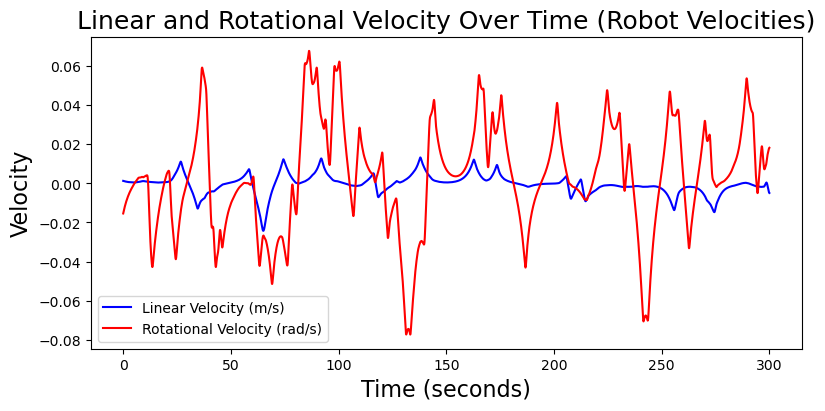

In [76]:
""" TODO
Create a plot that contains both the linear velocity (robot_vel[:,0]) and
rotational velocity (robot_vel[:,1]).  The plot should contain 
appropriate labels

Note: units are m/s and rad/s, respectively
"""

plt.figure()
# TODO

# Plot linear velocity (robot_vel[:,0])
plt.plot(time, robot_vel[:, 0], label='Linear Velocity (m/s)', color='blue')

# Plot rotational velocity (robot_vel[:,1])
plt.plot(time, robot_vel[:, 1], label='Rotational Velocity (rad/s)', color='red')

# Add labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity')
plt.title('Linear and Rotational Velocity Over Time (Robot Velocities)')

# Add legend
plt.legend()

# Display the plot
plt.show()

In [77]:
""" PROVIDED
Create labels that correspond to "fast forward motion" and
"fast left rotational motion"

"""
# Fast forward motion
labels_linear = robot_vel[:,0] > 0.002

# Rightward turns
labels_rotational_l = (robot_vel[:,1]) > 0.02
# Rightward turns
labels_rotational_r = (robot_vel[:,1]) < -0.02

<Figure size 800x400 with 0 Axes>

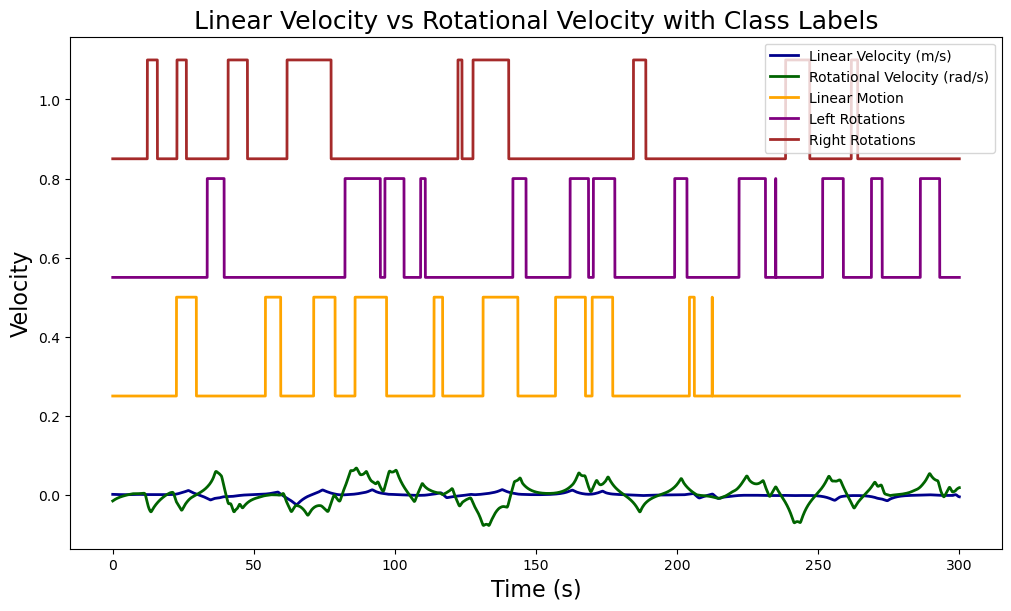

In [78]:
""" TODO
Augment the figure you created above to show the three newly-created
class labels.  Make sure that the resulting figure is easy to read
"""

plt.figure()
# TODO

plt.figure(figsize=(10, 6))
plt.plot(time, robot_vel[:, 0], color='darkblue', label='Linear Velocity (m/s)', lw=2)

plt.plot(time, robot_vel[:, 1], color='darkgreen', label='Rotational Velocity (rad/s)', lw=2)

plt.plot(time, labels_linear * 0.25 + 0.25, color='orange', label='Linear Motion', lw=2)

plt.plot(time, labels_rotational_l * 0.25 + 0.55, color='purple', label='Left Rotations', lw=2)

plt.plot(time, labels_rotational_r * 0.25 + 0.85, color='brown', label='Right Rotations', lw=2)


plt.title('Linear Velocity vs Rotational Velocity with Class Labels')
plt.xlabel('Time (s)')
plt.ylabel('Velocity')

plt.legend()

plt.show()


# Visualization Tools



In [79]:
'''
TODO: Complete the visualization implementations
'''
def visualize_model_output_timeseries(y, preds, scores, threshold=0, 
                                      offset_pred=-2, offset_scores=-8):
    '''
    Plot timeseries on a single axis:
    1. True class (y)
    2. Predicted class (preds)
    3. Prediction scores (scores)
    
    In addition, draw a horizontal line over the scores that shows the decision 
    threshold (by default the decision threshold is zero)
    
    Don't forget to supply a meaningful legend and to label the horizontal axis
    '''
    
    plt.figure()
    # TODO
    plt.plot(y, label='True Class', color='green',lw=2)
                                          
    plt.plot(preds + offset_pred, label='Predicted Class (preds)', color='blue',lw=2)

    
    plt.plot(scores + offset_scores, label='Prediction Scores(scores)', color='red',lw=2)
    #plt.plot([scores + offset_scores] * len(scores), label='Prediction Scores (scores)', color='red', lw=2)

  
    plt.axhline(y=threshold+offset_scores, color='black', linestyle='--', label='Threshold') 
    plt.title('Model Op timeseries')                                      
    plt.xlabel("Time (s)")
    plt.ylabel('values')                                     
    plt.legend(loc="best")
    plt.show()
    
'''
TODO

Generate a K-S plot and a ROC plot.

'''
def ks_roc_plot(targets, scores, FIGWIDTH=12, FIGHEIGHT=6, FONTSIZE=16):
    ''' 
    Generate a figure with two subplots:
    1.  TPR and FPR (and their difference) as a function of decision threshold
    2.  ROC Curve 
    
    On both subplots, clearly show the threshold that corresponds to the
    K-S distance using either a line or a point (choose the most appropriate
    one)
    
    :param targets: list of true target labels
    :param scores: list of predicted labels or scores
    :param FIGWIDTH: figure width
    :param FIGHEIGHT: figure height
    :param FONTSIZE: font size for text
        
    :return:
        fpr: false positive rate (vector)
        tpr: true positive rate (vector)
        thresholds: thresholds used for the ROC curve (vector)
        ind: the index in thresholds that corresponds to the K-S distance
        thr: the threshold that corresponds to the K-S distance
        auc: Area under the ROC Curve
        fig, axs: corresponding handles for the figure and axis
        
    '''
    # Compute fpr, tpr, thresholds
    fpr, tpr, thresholds =  roc_curve(targets, scores)# TODO
    # Compute AUC
    auc_res = auc(fpr, tpr)# TODO

    # Compute the difference between tpr and fpr
    diff = tpr-fpr
    # Compute the index that corresponds to the maximum difference
    ind = diff.argmax()# TODO
    # Compute the threshold for the maximum difference
    thr = thresholds[ind]# TODO
    #print(thr)

    # Generate figure with two axes
    fig, ax = plt.subplots(1, 2, figsize=(FIGWIDTH,FIGHEIGHT))
    axs = ax.ravel()  # Individual axes are now ax[0] and ax[1]
    
    # TODO: plot TPR, FPR and difference
    axs[0].plot(thresholds, tpr, label='TPR',color='green')
    axs[0].plot(thresholds, fpr, label='FPR',color='red')
    axs[0].plot(thresholds, diff, label='TPR - FPR',color='blue')
    # TODO
    axs[0].axvline(thr, color='black', linestyle='--', label=f'K-S Threshold: {thr:.2f}')
    axs[0].set_xlabel('Threshold')
    axs[0].set_ylabel('Rate')
    axs[0].legend(loc='best')
    axs[0].set_title('TPR, FPR, and their Difference')
    #axs[0].axvline(x=thr, color='green', linestyle='--', label=f'Threshold = {thr:.2f} (Max K-S Distance)')
        
    # TODO: Generate ROC Curve plot
    # TODO
    axs[1].plot(fpr, tpr, label=f'AUC = {auc_res:.2f}',color='blue')
    axs[1].plot([0,1],[0,1], color='green',linestyle='--',label='Random Classifier')
    axs[1].scatter(fpr[ind], tpr[ind], color='red', label=f'K-S Point (Threshold: {thr:.2f})')
    #axs[1].scatter(fpr[ind], tpr[ind], c='green', label=f'Max K-S Distance = {diff[ind]:.2f}')
    axs[1].set_xlabel('FPR')
    axs[1].set_ylabel('TPR')
    axs[1].set_title('ROC Curve')
    axs[1].legend(loc='best')

    plt.show()

    return fpr, tpr, thresholds, ind, thr, auc_res, fig, axs


""" 
TODO

Plot histograms of the scores from the model.
"""

def plot_score_histograms(scores, y, thr=None, nbins = 41, 
                          FIGWIDTH=8, FIGHEIGHT=4):
    '''
    Generate two plots (in a single figure):
    1. Histogram of all scores
    2. Two overlapping histograms: one for positive examples 
            and the other for negative examples
    
    :param scores: Model scores for all samples
    :param y: Ground truth labels for all samples
    :param thr: Threshold to indicate on the plot
    :param nbins: Number of bins used for the histograms
    :param FIGWIDTH: Figure width
    :param FIGHIGHT: Figure height
    '''

    # Given all the scores and the true class labels, create
    #  lists of scores for the positive and negative cases, respctively
    scores_pos = scores[y == 1] # TODO
    scores_neg = scores[y == 0]# TODO

    plt.figure(figsize=(FIGWIDTH, FIGHEIGHT))
    plt.subplot(1,2,1)
    plt.hist(scores, bins=nbins, color='gray', alpha=0.7)
   
    n, bins, patches = plt.hist(scores, bins=nbins, color='gray', alpha=0.7)# TODO
    if thr is not None:
        plt.axvline(x=thr, color='red', linestyle='--', label=f'Threshold: {thr}')
        
    plt.xlabel('score')
    plt.ylabel('count')

    plt.subplot(1,2,2)
    n1, bins1, patches1 =  plt.hist(scores_pos, bins=nbins, alpha=0.6, color='green', label='Positive')# TODO
    n2, bins2, patches2 =  plt.hist(scores_neg, bins=nbins, alpha=0.6, color='red', label='Negative')# TODO
    if thr is not None:
        plt.axvline(x=thr, color='black', linestyle='--', label=f'Threshold: {thr}')
    plt.xlabel('score')
    plt.title('Positive vs Negative Scores')
    plt.legend(loc='upper right')
    plt.show()

# First Classifier
Create an instance of the SGDClassifier and fit our entire data set using this data.

Details: Random_state=1138, max_iter=1e4, tol=1e-3, and
that uses the log_loss function. Fit the model using the position x, y, z
and velocity x, y, z for all limbs as the input features to the model. Use
the robot linear velocity labels as the output of the model.

In [80]:
""" TODO
"""
# Input
X = inputs_pos_vel

# Desired output
y = labels_linear

# TODO: Create and fit the classifer
clf = SGDClassifier(loss='log_loss', random_state=1138, max_iter=int(1e4), tol=1e-3) # TODO
clf.fit(X, y)
# TODO: extract the predictions and the decision function scores from the model 
#  for the entire data set
preds = clf.predict(X)  # TODO
#print(preds)
scores = clf.decision_function(X) # TODO
#print(scores)

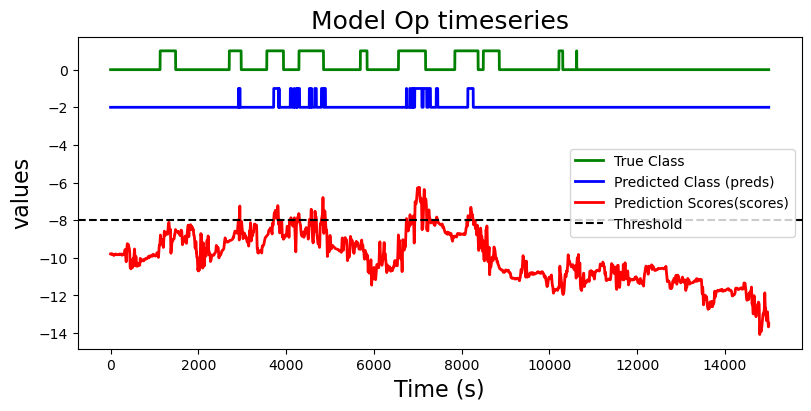

In [81]:
# Visualize the predictions made by the model in timeseries form
visualize_model_output_timeseries(y, preds, scores)

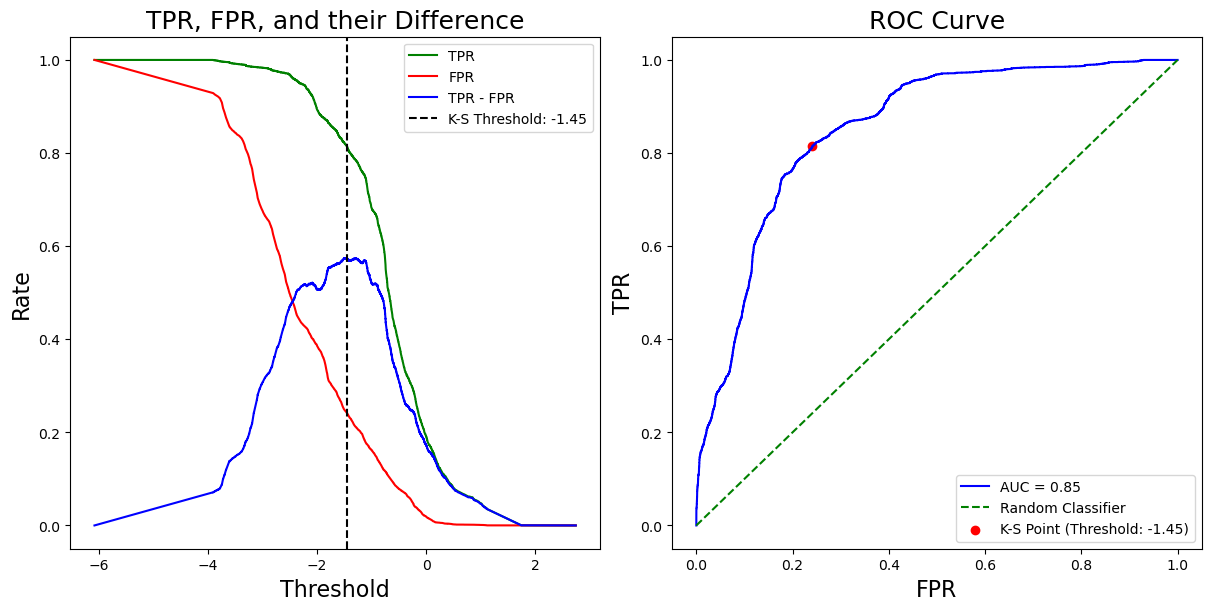

In [82]:
# Generate the TPR/FPR and ROC plots
fpr, tpr, thresholds, ind_max, thr_max, auc_res, fig, axs = ks_roc_plot(y, scores) 

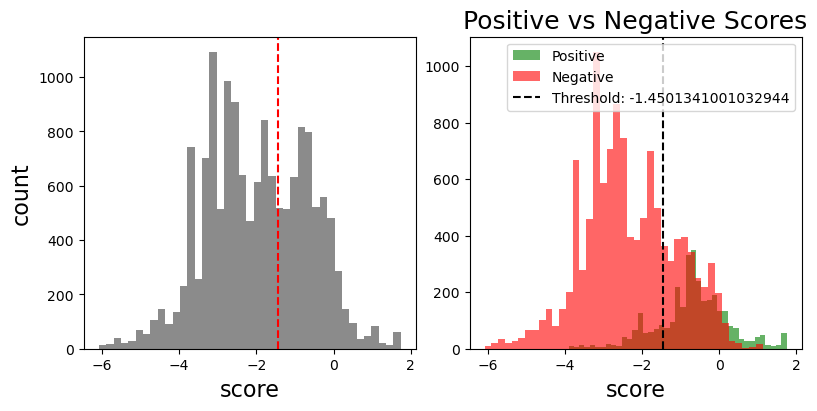

In [83]:
# Plot score histograms
plot_score_histograms(scores, y, thr = thr_max)



# Rotational Velocity Classifier

Create a new classifier that predicts the 'fast rotational velocity right' label.

Use the same parameters for the SGDClassifier as above

In [84]:
""" TODO
"""
# Input
X = inputs_pos_vel

# Desired output
y = labels_rotational_r

# TODO: Create and fit the classifer
clf = SGDClassifier(loss='log_loss', random_state=1138, max_iter=int(1e4), tol=1e-3) # TODO
clf.fit(X, y)

# TODO: extract the predictions and the decision function scores from the model for the entire data set
preds = clf.predict(X)# TODO

scores = clf.decision_function(X)# TODO

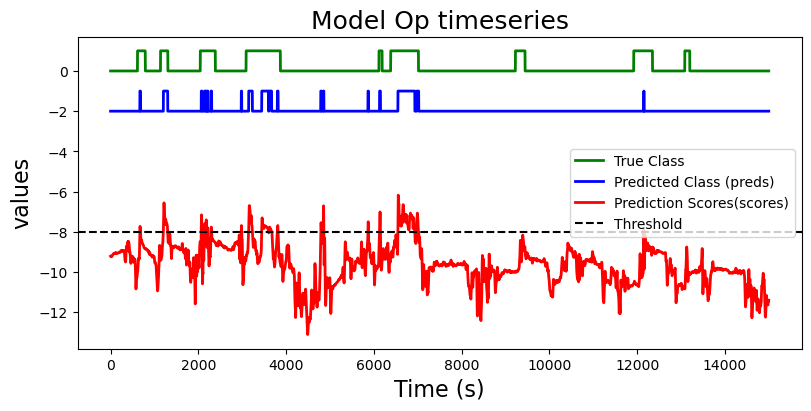

In [85]:
# Visualize the predictions made by the model in timeseries form
visualize_model_output_timeseries(y, preds, scores)

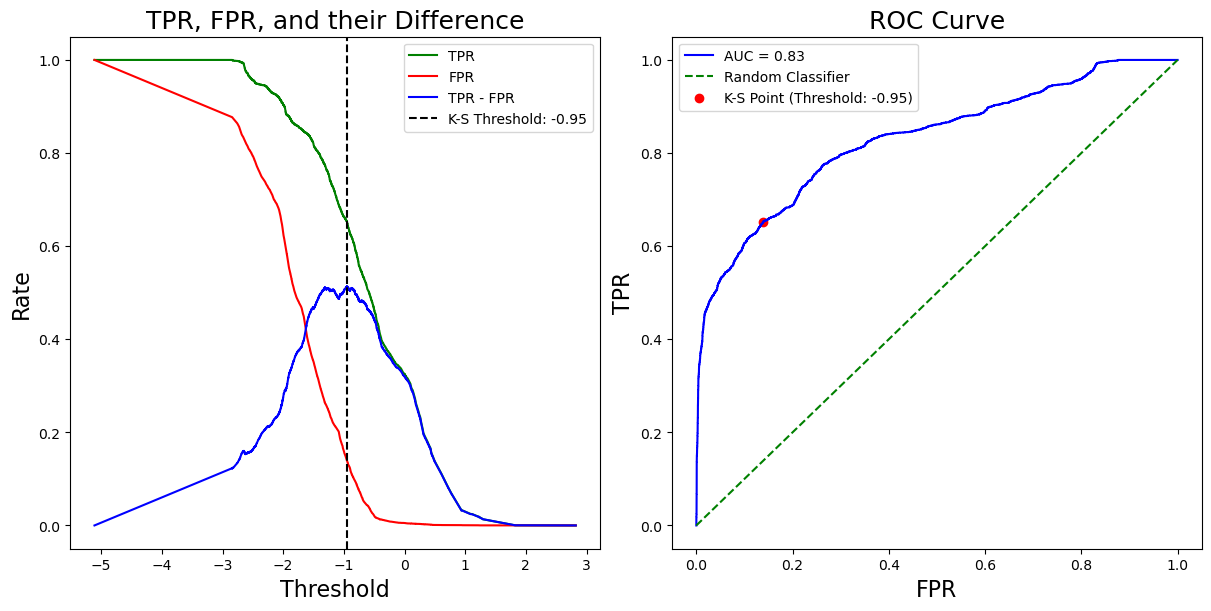

In [86]:
# Generate the TPR/FPR and ROC plots
fpr, tpr, thresholds, ind_max, thr_max, auc_res, fig, axs = ks_roc_plot(y, scores) 

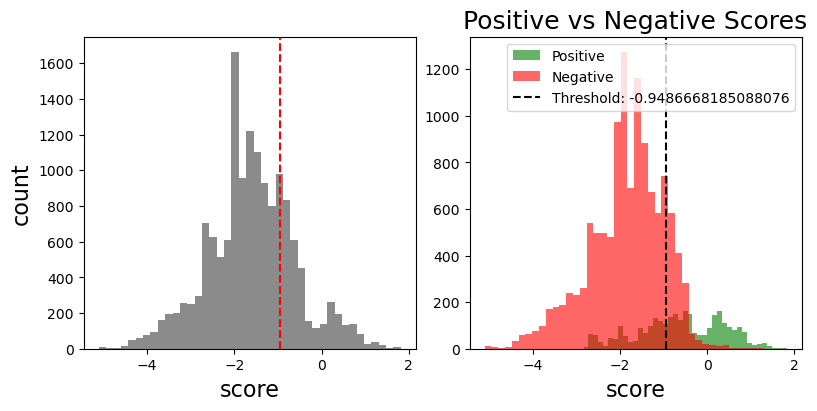

In [87]:
# Plot score histograms
plot_score_histograms(scores, y, thr=thr_max)


# Reflection
Please provide short answers to each of the questions (1-2 sentences)

_Q1. Which score threshold corresponds to the Kolmogorov-Schmirnov Distance for the rotational velocity classifier?_

**ANS** The blue line represents the difference between the True Positive Rate (TPR) and False Positive Rate (FPR). The maximum point on this curve corresponds to the Kolmogorov-Smirnov distance. The dashed line shows that the KS threshold occurs at a score of -0.95
 

_Q2. Increasing the threshold increases or decreases the True Positive Rate?_

**ANS** Increasing the threshold usually decreases the True Positive Rate because the classifier becomes more strict, catching fewer correct positive predictions.


_Q3. Decreasing the threshold increases or decreases the difference between the True Positive Rate and the False Positive Rate?_

**ANS** Decreasing the threshold typically increases the gap between the True Positive Rate and False Positive Rate at first, because more correct positives are identified. 


_Q4. Comparing the two models, which one better separates the positive from the negative examples?  How are you evaluating this?_

**ANS** The first model, with an AUC of 0.85, separates positive and negative examples better than the second model, which has an AUC of 0.83 ( An AUC of 1.0 means perfect separation ). I evaluated this by comparing their AUC values, with a higher AUC indicating better separation.


_Q5. Which of the two models exhibit the highest Kolmogorov-Schmirnov Distance?_

**ANS** The model with the higher Kolmogorov-Smirnov (KS) Distance is the one where the difference between the True Positive Rate (TPR) and False Positive Rate (FPR) is greatest. By observation, the first model exhibits the higher Kolmogorov-Schmirnov Distance.

Based on the information provided and the plots, the first model exhibits the highest Kolmogorov-Smirnov Distance



_Q6. Did your pre-processing stage eliminate all of the NaNs in your data?  How do you know?_

***ANS*** Yes, all NaNs were successfully removed in the pre-processing step. I confirmed this by checking the data with functions like isna().any(), which returned zeros for all columns, indicating no missing values remained.
baby_data_clean.isna().any() - Produces all false and the dtype as bool